#프로젝트 소개
U-Net 기법을 활용하여 COVID-19 관련 폐 질환의 이미지 세분화(Image Segmentation)를 구현한 프로젝트

# 주요 기능
● TensorFlow Dataset을 생성하여 의료 기반에 최적화된 U-Net 아키텍처 모델에 입력하도록 설계

● 메모리 부족 현상이 나타나므로 이미지 사이즈를 224 x 224로 설정

● U-Net에 효과적인 데이터 증강 기법 사용(랜덤 회전 , 랜덤플립)

● 코사인 스케줄링을 사용하여 학습률을 점진적으로 감소시킴으로써, 모델이 더 안정적이고 효과적으로 수렴하며, 과적합을 방지할 수 있도록 유도

● 82번의 훈련을 통해 Train accuracy 96% Train Loss 9% , Val accuracy 95% Val Loss 13% 달성

● 메모리 부족 현상이 없다면 이미지 사이즈 및 배치 사이즈 등  하이퍼파라미터를 조정하여 더 좋은 성능을 얻을 수 있을거라고 추정


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


구글 코랩 TPU 설정  https://colab.research.google.com/notebooks/tpu.ipynb

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.15.0
Running on a TPU w/8 cores


데이터셋의 이미지의 사이즈 확인(모든 이미지의 크기 - 299 x 299 x 3)

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/chest/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png')
img.shape

(299, 299, 3)

COVID-19 Chest X-ray 이미지와 마스크 데이터를 로드하고, 각 카테고리에 맞게 레이블을 적용(총 이미지 21165장)

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm

image_path = '/content/drive/MyDrive/chest/COVID-19_Radiography_Dataset'

images = []
masks = []


categories = sorted(os.listdir(image_path))
if '.ipynb_checkpoints' in categories:
    categories.remove('.ipynb_checkpoints')
num_categories = len(categories)

total_files = 0
for category in categories:
    image_folder = os.path.join(image_path, category, 'images')
    total_files += len([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])

#tqdm을 사용하여 전체 진행 상태 표시
with tqdm(total=total_files, desc="Overall Progress") as pbar:
    for category_index, category in enumerate(categories):
        image_folder = os.path.join(image_path, category, 'images')
        mask_folder = os.path.join(image_path, category, 'masks')

        for image_name in os.listdir(image_folder):
            if image_name.endswith('.png'):
                img_full_path = os.path.join(image_folder, image_name)
                mask_full_path = os.path.join(mask_folder, image_name)

                img = cv2.imread(img_full_path)
                img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                mask = cv2.imread(mask_full_path, 0)
                mask = np.where(mask > 0, category_index, mask)

                images.append(img_cvt)
                masks.append(mask)

                pbar.update(1)

Overall Progress: 100%|██████████| 21165/21165 [1:36:08<00:00,  3.67it/s]


성능 최적화를 위해 이미지와 마스크 리스트를 넘파이 형태로 변환

TPU 사용 시, 파일 단위 데이터를 직접 처리하는 대신 넘파이 배열로 미리 준비하면 TensorFlow Dataset 생성 및 데이터 로드 속도가 크게 향상(수십 분 -> 초 단위)

In [ ]:
import numpy as np
images = np.asarray(images)
masks = np.asarray(masks)

images , masks 리스트를 X_train 과 X_val로 분할(Train에 80%, Validation에 20% 할당)

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , masks , test_size = 0.2)

U-Net에 효과적인 데이터 증강 기법 사용(랜덤 회전 , 랜덤플립)

In [ ]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.05),             #랜덤 회전
    tf.keras.layers.RandomFlip(mode='horizontal')            #랜덤 플립
])

이미지 및 마스크 사이즈를 224 x 224로 설정(256 x 256 이상으로 설정 시 메모리 부족 현상 발생)

차례대로 이미지 크기를 지정된 크기로 조정해주는 전처리 함수 , 이미지 증강 함수, 이미지와 레이블을 TensorFlow 데이터셋으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 Tensorflow 데이터셋 생성 함수 정의

In [ ]:
img_size = (224 , 224 , 3)

#이미지 크기를 지정된 크기로 조정해주는 함수
import tensorflow as tf
def preprocessing_data(image , label):
  image = tf.image.resize(image , img_size[:2])
  label = tf.image.resize(label[... , tf.newaxis] , img_size[:2])
  return image , label

#이미지에 이미지 증강을 적용해주는 함수
def augment_image(image , label):
  image = data_augmentation(image)
  return image , label

#이미지와 레이블을 tensorflow dataset으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 함수
def create_tensorflow_dataset(images , labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_data , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.cache()
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

메모리 부족 현상을 해결하기 위해 배치 사이즈를 32로 설정

In [ ]:
global_batch_size = 32 * tpu_strategy.num_replicas_in_sync

앞서 정의한 TensorFlow Dataset 함수를 이용하여 Train_dataset 및 Val_dataset 데이터셋 생성(Train_dataset에만 데이터 증강 적용)

In [ ]:
train_dataset = create_tensorflow_dataset(X_train, y_train, batch_size = global_batch_size , buffer_size = len(X_train), augment = True)
val_dataset = create_tensorflow_dataset(X_val, y_val, batch_size = global_batch_size , buffer_size = len(X_val), augment = False)

인코더와 디코더로 이루어진 U-Net 아키텍처 구현

In [ ]:
def unet_model(input_size=(224 , 224, 3), num_classes= 4, dropout_rate=0.3):
    inputs = tf.keras.layers.Input(input_size)

    #Encoder
    c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    c5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)

    #Decoder
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4], axis=-1)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3], axis=-1)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2], axis=-1)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=-1)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

학습률 스케줄링 (Cosine decay) 구현

In [ ]:
initial_lr = 0.001  #초기 학습률
epochs = 200
batch_size = 32
steps_per_epoch = 529  #한 epoch에 대한 steps 수(전체 훈련 데이터 샘플 수 / 배치 크기)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_lr,
    decay_steps = epochs * steps_per_epoch,  #총 step 수
    alpha = 0.0  #학습률 최솟값
)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

82번의 훈련을 통해 Train accuracy 96% Train Loss 9% , Val accuracy 95% Val Loss 13% 달성

메모리 부족 현상이 없다면 이미지 사이즈 및 배치 사이즈를 조정하여 더 좋은 성능을 얻을 수 있을거라고 추정

In [ ]:
with tpu_strategy.scope():
    model = unet_model(input_size = (224, 224 , 3), dropout_rate = 0.3)
    model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = optimizer , metrics = ['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30)

history = model.fit(train_dataset, epochs = 200 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/200
265/265 [==============================] - 149s 389ms/step - loss: 0.6009 - accuracy: 0.8037 - val_loss: 0.6215 - val_accuracy: 0.7693
Epoch 2/200
265/265 [==============================] - 58s 207ms/step - loss: 0.3962 - accuracy: 0.8553 - val_loss: 0.5599 - val_accuracy: 0.7940
Epoch 3/200
265/265 [==============================] - 60s 208ms/step - loss: 0.3397 - accuracy: 0.8720 - val_loss: 0.3680 - val_accuracy: 0.8632
Epoch 4/200
265/265 [==============================] - 58s 204ms/step - loss: 0.2988 - accuracy: 0.8856 - val_loss: 0.2791 - val_accuracy: 0.9026
Epoch 5/200
265/265 [==============================] - 59s 204ms/step - loss: 0.2757 - accuracy: 0.8934 - val_loss: 0.2561 - val_accuracy: 0.9064
Epoch 6/200
265/265 [==============================] - 58s 204ms/step - loss: 0.2596 - accuracy: 0.8989 - val_loss: 0.2174 - val_accuracy: 0.9160
Epoch 7/200
265/265 [==============================] - 57s 203ms/step - loss: 0.2455 - accuracy: 0.9044 - val_loss: 0.2119 

Matplotlib를 통해 훈련 및 검증 데이터 손실 , 정확도 시각화

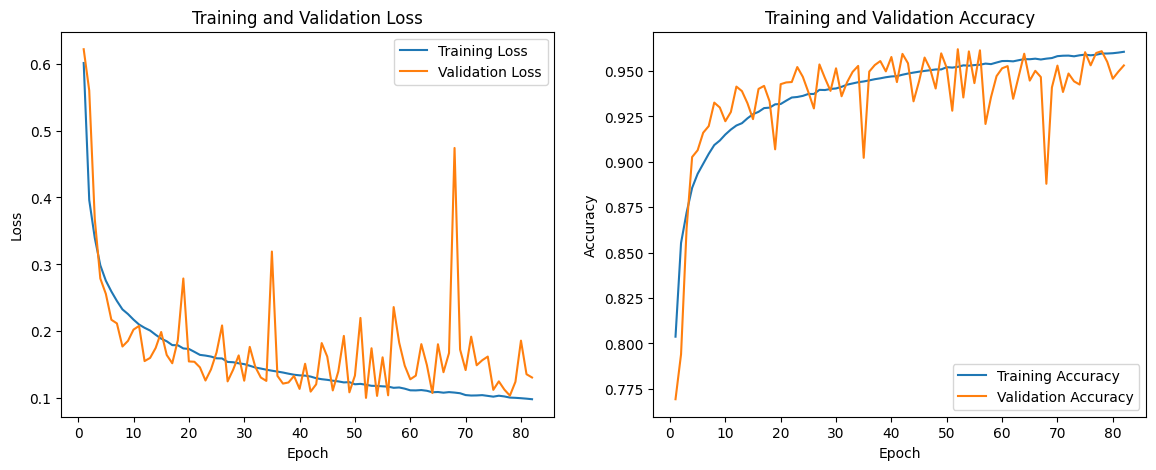

In [ ]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs = range(1 , len(loss) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize = (14, 5))

# Training and Validation Loss plot
plt.subplot(121)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy plot
plt.subplot(122)
plt.plot(epochs, accuracy, label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

val_dataset에 대해 original_image , true mask , predicted_mask 시각화

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, categories, num_images = 5):
    for images, true_masks in dataset.take(num_images):
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1)

        for i in range(len(images)):
            category_index = tf.reduce_max(true_masks[i]).numpy().astype(int)
            category_name = categories[category_index]

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(tf.cast(images[i], tf.uint8))
            axs[0].set_title(f"Original: {category_name}")
            axs[0].axis('off')

            axs[1].imshow(tf.cast(true_masks[i], tf.uint8), cmap='gray')
            axs[1].set_title("True Mask")
            axs[1].axis('off')

            axs[2].imshow(predicted_masks[i], cmap='gray')
            axs[2].set_title("Predicted Mask")
            axs[2].axis('off')

            plt.show()

visualize_prediction(model, val_dataset, categories)